In [154]:
import numpy as np
import cfgrib
import xarray as xr
import salem

In [3]:
# FILENAME = '/Users/JackKelly/data/weather_forecasts/UKV/2017/01/01/201701010000_u1096_ng_umqv_Wholesale1_mod.grib'
FILENAME = '/Users/JackKelly/data/weather_forecasts/UKV/2019/08/29/201908290000_u1096_ng_umqv_Wholesale1.grib'
# FILENAME = '/Users/JackKelly/data/weather_forecasts/UKV/2015/06/01/prodm_op_ukv_20150601_03_000.pp'

In [101]:
cfgrib.open_dataset?

Signature: cfgrib.open_dataset(path, **kwargs)
Docstring: Return a ``xr.Dataset`` with the requested ``backend_kwargs`` from a GRIB file.
File:      ~/miniconda3/envs/nwp/lib/python3.7/site-packages/cfgrib/xarray_store.py
Type:      function


In [113]:
datasets = cfgrib.open_datasets(FILENAME)

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


In [114]:
len(datasets)

6

Variable names in wholesale1
* r = relative humidity
* t = temperature
* dpt = dew point temperature
* vis = visability
* si10 = 10 metre wind speed, m/s
* wdir10 = 10 metre wind direction, Degree true
* prmsl = Pressure reduced to MSL
* prate = Precipitation rate

In [123]:
# Find the dataset with wind speed & direction in it
for ds in datasets:
    if 'si10' in ds and 'wdir10' in ds:
        break
else:
    raise ValueError('Could not find si10 and wdir10 in any dataset!')

In [125]:
ds.dims

Frozen(SortedKeysDict({'step': 37, 'values': 385792}))

In [126]:
ds.coords

Coordinates:
    time               datetime64[ns] 2019-08-29
  * step               (step) timedelta64[ns] 00:00:00 ... 1 days 12:00:00
    heightAboveGround  int64 10
    valid_time         (step) datetime64[ns] 2019-08-29 ... 2019-08-30T12:00:00

In [127]:
ds.attrs

OrderedDict([('GRIB_edition', 2),
             ('GRIB_centre', 'egrr'),
             ('GRIB_centreDescription', 'U.K. Met Office - Exeter'),
             ('GRIB_subCentre', 0),
             ('Conventions', 'CF-1.7'),
             ('institution', 'U.K. Met Office - Exeter')])

In [128]:
data = ds['si10']

In [129]:
data.attrs

OrderedDict([('GRIB_paramId', 207),
             ('GRIB_shortName', '10si'),
             ('GRIB_units', 'm s**-1'),
             ('GRIB_name', '10 metre wind speed'),
             ('GRIB_cfVarName', 'si10'),
             ('GRIB_dataType', 'af'),
             ('GRIB_missingValue', 9999),
             ('GRIB_numberOfPoints', 385792),
             ('GRIB_typeOfLevel', 'heightAboveGround'),
             ('GRIB_NV', 0),
             ('GRIB_stepUnits', 1),
             ('GRIB_stepType', 'instant'),
             ('GRIB_gridType', 'transverse_mercator'),
             ('GRIB_gridDefinitionDescription', '12'),
             ('long_name', '10 metre wind speed'),
             ('units', 'm s**-1')])

37

In [130]:
# Data from page 4 of this Met Office PDF
# http://cedadocs.ceda.ac.uk/1334/1/uk_model_data_sheet_lores1.pdf
lon_centre = (6.371 - 13.643) / 2
lat_centre = (60.884 + 47.926) / 2

# Define a transverse mercator grid
grid = salem.mercator_grid(
    center_ll=(lon_centre, lat_centre), # tuple of lon, lat coordinates where the map will be centered
    extent=(1096000, 1408000), # tuple of eastings, northings giving the extent (in m) of the map
    ny=704,
    #nx=548,
    origin='lower-left',
    transverse=True)

grid

<salem.Grid>
  proj: +datum=WGS84 +k=0.9996 +lat_0=0 +lon_0=-3.636 +no_defs+proj=tmerc +units=m +x_0=0 +y_0=0
  pixel_ref: corner
  origin: lower-left
  (nx, ny): (548, 704)
  (dx, dy): (2000.0, 2000.0)
  (x0, y0): (-548000.0, 5324583.682105267)

In [131]:
grid.extent_in_crs()

[-13.593333946482867, 6.321333946482866, 47.8402665929299, 60.72882878338798]

{'imshow': <matplotlib.image.AxesImage at 0x7fd589341e10>,
 'contour': [],
 'contourf': []}

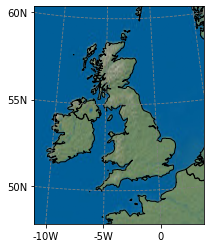

In [132]:
smap = salem.Map(grid)

# Add the background (other resolutions include: 'mr', 'hr')
smap.set_rgb(natural_earth='lr')
smap.visualize()

In [133]:
lon, lat = grid.ll_coordinates

In [134]:
data.coords

Coordinates:
    time               datetime64[ns] 2019-08-29
  * step               (step) timedelta64[ns] 00:00:00 ... 1 days 12:00:00
    heightAboveGround  int64 10
    valid_time         (step) datetime64[ns] 2019-08-29 ... 2019-08-30T12:00:00

In [135]:

new_data_1 = data.expand_dims({
    'lon': range(548),
    'lat': range(704)
})
new_data_1.salem.grid = grid

# This hangs!
# Prob need to reshape the values to be <timesteps>, <lat>, <lon> or something like that!
# new_data_1.salem.quick_map()

In [156]:
new_da = xr.DataArray(
    data.values.reshape((len(data['step']), 704, -1)),
    dims=['step', 'lat', 'lon'],
    coords={
        'step': data['step'],
        'lat': np.arange(704, dtype=np.uint16), 
        'lon': np.arange(548, dtype=np.uint16)}
)
new_da

<xarray.DataArray (step: 37, lat: 704, lon: 548)>
array([[[5.15, 5.05, ..., 0.05, 0.05],
        [5.35, 5.25, ..., 0.05, 0.05],
        ...,
        [4.75, 4.75, ..., 1.75, 1.85],
        [4.95, 4.85, ..., 1.75, 1.85]],

       [[4.65, 4.65, ..., 0.05, 0.05],
        [4.85, 4.75, ..., 0.65, 0.05],
        ...,
        [6.15, 6.15, ..., 1.85, 1.75],
        [6.35, 6.25, ..., 1.65, 1.65]],

       ...,

       [[5.15, 5.35, ..., 0.05, 0.05],
        [5.15, 5.35, ..., 0.95, 0.05],
        ...,
        [7.55, 7.55, ..., 1.05, 1.15],
        [7.45, 7.35, ..., 1.15, 1.15]],

       [[5.45, 5.45, ..., 0.05, 0.05],
        [5.45, 5.35, ..., 1.55, 0.05],
        ...,
        [8.15, 8.15, ..., 0.85, 0.85],
        [8.15, 8.15, ..., 0.85, 0.85]]], dtype=float32)
Coordinates:
  * step     (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * lat      (lat) uint16 0 1 2 3 4 5 6 7 8 ... 696 697 698 699 700 701 702 703
  * lon      (lon) uint16 0 1 2 3 4 5 6 7 8 ... 540 541 542 543 544 545

In [146]:
new_da.salem.grid = grid

In [165]:
tslice = new_da.isel(step=0)

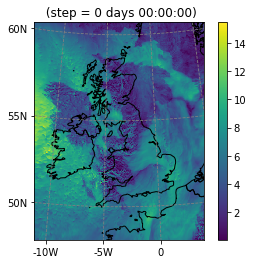

In [166]:
tslice.salem.grid = grid
tslice.salem.quick_map()

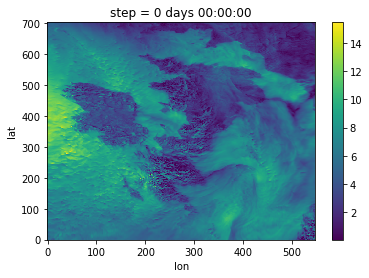

In [183]:
tslice.plot.pcolormesh()

In [139]:
lon_query = -13.5
lat_query = 61
grid.transform(lon_query, lat_query, nearest=True)

(7, 739)

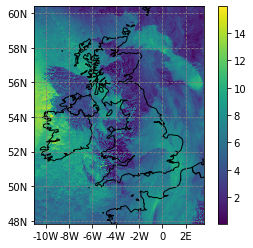

In [150]:
# Plot, but wrong projection
xr.DataArray(
    data.values[1].reshape((704, -1)),
    dims=['lat', 'lon'],
    coords={'lat': lat[:, 0], 'lon': lon[0, :]}).salem.quick_map();

In [49]:
grid.proj.definition_string()

'proj=tmerc lat_0=0 lon_0=-3.636 k=0.9996 x_0=0 y_0=0 datum=WGS84 units=m no_defs ellps=WGS84 towgs84=0,0,0'

In [167]:
from salem.utils import get_demo_file

In [168]:
salem_ds = salem.open_xr_dataset(get_demo_file('wrfout_d01.nc'))

In [169]:
salem_ds

<xarray.Dataset>
Dimensions:      (Time: 3, bottom_top: 27, bottom_top_stag: 28, south_north: 150, south_north_stag: 151, west_east: 150, west_east_stag: 151)
Coordinates:
    XLONG        (Time, south_north, west_east) float32 ...
    XLONG_U      (Time, south_north, west_east_stag) float32 ...
    XLAT_U       (Time, south_north, west_east_stag) float32 ...
    XLAT_V       (Time, south_north_stag, west_east) float32 ...
    XLONG_V      (Time, south_north_stag, west_east) float32 ...
    XLAT         (Time, south_north, west_east) float32 ...
  * west_east    (west_east) float64 -2.235e+06 -2.205e+06 ... 2.235e+06
  * south_north  (south_north) float64 -2.235e+06 -2.205e+06 ... 2.235e+06
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, south_north_stag, west_east_stag
Data variables:
    Times        (Time) |S19 ...
    T2           (Time, south_north, west_east) float32 ...
    RAINC        (Time, south_north, west_east) float32 ...
    RAINNC       (Time, south_n

In [170]:
salem_ds.salem.grid

<salem.Grid>
  proj: +R=6370000 +lat_0=29.0399971008301 +lat_1=29.0400009155273 +lat_2=29.0400009155273 +lon_0=89.8000030517578 +no_defs+proj=lcc +units=m +x_0=0 +y_0=0
  pixel_ref: center
  origin: lower-left
  (nx, ny): (150, 150)
  (dx, dy): (30000.0, 30000.0)
  (x0, y0): (-2235001.483159773, -2234999.9999999036)

In [172]:
salem_ds['U']

<xarray.DataArray 'U' (Time: 3, bottom_top: 27, south_north: 150, west_east_stag: 151)>
[1834650 values with dtype=float32]
Coordinates:
    XLONG_U      (Time, south_north, west_east_stag) float32 ...
    XLAT_U       (Time, south_north, west_east_stag) float32 ...
  * south_north  (south_north) float64 -2.235e+06 -2.205e+06 ... 2.235e+06
Dimensions without coordinates: Time, bottom_top, west_east_stag
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  x-wind component
    units:        m s-1
    stagger:      X
    pyproj_srs:   +proj=lcc +lat_0=29.0399971008301 +lon_0=89.8000030517578 +...

In [173]:
salem_ds['U']['XLONG_U']

<xarray.DataArray 'XLONG_U' (Time: 3, south_north: 150, west_east_stag: 151)>
array([[[ 70.59735 ,  70.84897 , ..., 108.75104 , 109.002686],
        [ 70.55597 ,  70.808105, ..., 108.79187 , 109.04404 ],
        ...,
        [ 61.688477,  62.04953 , ..., 117.550476, 117.91156 ],
        [ 61.600586,  61.962708, ..., 117.6373  , 117.99939 ]],

       [[ 70.59735 ,  70.84897 , ..., 108.75104 , 109.002686],
        [ 70.55597 ,  70.808105, ..., 108.79187 , 109.04404 ],
        ...,
        [ 61.688477,  62.04953 , ..., 117.550476, 117.91156 ],
        [ 61.600586,  61.962708, ..., 117.6373  , 117.99939 ]],

       [[ 70.59735 ,  70.84897 , ..., 108.75104 , 109.002686],
        [ 70.55597 ,  70.808105, ..., 108.79187 , 109.04404 ],
        ...,
        [ 61.688477,  62.04953 , ..., 117.550476, 117.91156 ],
        [ 61.600586,  61.962708, ..., 117.6373  , 117.99939 ]]], dtype=float32)
Coordinates:
    XLONG_U      (Time, south_north, west_east_stag) float32 70.59735 ... 117.99939
    XLAT_

In [174]:
from pyproj import CRS

In [177]:
CRS.from_proj4(grid.proj.srs)

<Projected CRS: +proj=tmerc +lat_0=0 +lon_0=-3.636 +k=0.9996 +x_0= ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [178]:
import cartopy.crs as ccrs

In [179]:
ccrs.TransverseMercator?

Init signature:
ccrs.TransverseMercator(
    central_longitude=0.0,
    central_latitude=0.0,
    false_easting=0.0,
    false_northing=0.0,
    scale_factor=1.0,
    globe=None,
)
Docstring:      A Transverse Mercator projection.
Init docstring:
Parameters
----------
central_longitude: optional
    The true longitude of the central meridian in degrees.
    Defaults to 0.
central_latitude: optional
    The true latitude of the planar origin in degrees. Defaults to 0.
false_easting: optional
    X offset from the planar origin in metres. Defaults to 0.
false_northing: optional
    Y offset from the planar origin in metres. Defaults to 0.
scale_factor: optional
    Scale factor at the central meridian. Defaults to 1.
globe: optional
    An instance of :class:`cartopy.crs.Globe`. If omitted, a default
    globe is created.
File:           ~/miniconda3/envs/nwp/lib/python3.7/site-packages/cartopy/crs.py
Type:           ABCMeta
Subclasses:     OSGB, OSNI


In [180]:
air = xr.tutorial.open_dataset('air_temperature').air

In [181]:
air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
[3869000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [182]:
grid.ij_coordinates

[array([[  0,   1,   2, ..., 545, 546, 547],
        [  0,   1,   2, ..., 545, 546, 547],
        [  0,   1,   2, ..., 545, 546, 547],
        ...,
        [  0,   1,   2, ..., 545, 546, 547],
        [  0,   1,   2, ..., 545, 546, 547],
        [  0,   1,   2, ..., 545, 546, 547]]),
 array([[  0,   0,   0, ...,   0,   0,   0],
        [  1,   1,   1, ...,   1,   1,   1],
        [  2,   2,   2, ...,   2,   2,   2],
        ...,
        [701, 701, 701, ..., 701, 701, 701],
        [702, 702, 702, ..., 702, 702, 702],
        [703, 703, 703, ..., 703, 703, 703]])]

In [340]:
KM_TO_M = 1000

NORTH = 1223 * KM_TO_M
SOUTH = -185 * KM_TO_M
WEST = -239 * KM_TO_M
EAST = 857 * KM_TO_M

DY = DX = 2 * KM_TO_M


In [341]:
num_time_steps = len(data['step'])

new_da2 = xr.DataArray(
    data.values.reshape((num_time_steps, 704, 548)),
    dims=['step', 'northing', 'easting'],
    coords={
        'step': data['step'],
        'northing': np.arange(start=NORTH, stop=SOUTH, step=-DY, dtype=np.int32),
        'easting': np.arange(start=WEST, stop=EAST, step=DX, dtype=np.int32)
    }
)
new_da2

<xarray.DataArray (step: 37, northing: 704, easting: 548)>
array([[[5.15, 5.05, ..., 0.05, 0.05],
        [5.35, 5.25, ..., 0.05, 0.05],
        ...,
        [4.75, 4.75, ..., 1.75, 1.85],
        [4.95, 4.85, ..., 1.75, 1.85]],

       [[4.65, 4.65, ..., 0.05, 0.05],
        [4.85, 4.75, ..., 0.65, 0.05],
        ...,
        [6.15, 6.15, ..., 1.85, 1.75],
        [6.35, 6.25, ..., 1.65, 1.65]],

       ...,

       [[5.15, 5.35, ..., 0.05, 0.05],
        [5.15, 5.35, ..., 0.95, 0.05],
        ...,
        [7.55, 7.55, ..., 1.05, 1.15],
        [7.45, 7.35, ..., 1.15, 1.15]],

       [[5.45, 5.45, ..., 0.05, 0.05],
        [5.45, 5.35, ..., 1.55, 0.05],
        ...,
        [8.15, 8.15, ..., 0.85, 0.85],
        [8.15, 8.15, ..., 0.85, 0.85]]], dtype=float32)
Coordinates:
  * step      (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * northing  (northing) int32 1223000 1221000 1219000 ... -181000 -183000
  * easting   (easting) int32 -239000 -237000 -235000 ... 851000 8

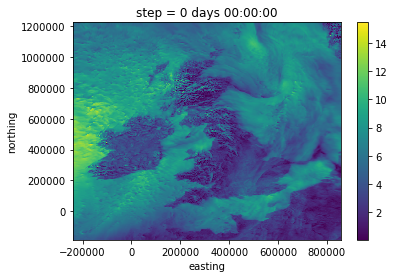

In [342]:
new_da2.isel(step=0).plot.pcolormesh()

In [356]:
from cartopy.crs import Globe
import shapely.geometry as sgeom

In [441]:
class UKVDomain(ccrs.OSGB):
    @property
    def x_limits(self):
        return (WEST, EAST)
    
    @property
    def y_limits(self):
        return (SOUTH, NORTH)
    
    @property
    def boundary(self):
        return sgeom.LineString([
            (WEST, SOUTH), 
            (WEST, NORTH), 
            (EAST, NORTH), 
            (EAST, SOUTH), 
            (WEST, SOUTH)])

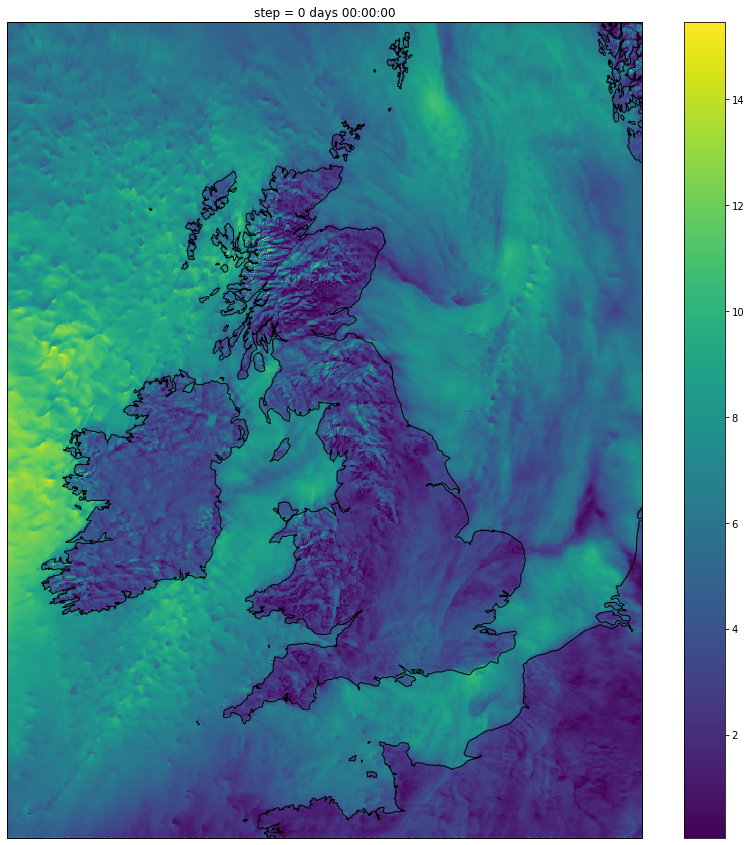

In [446]:
fig = plt.figure(figsize=(15, 15))
#ax = plt.axes(projection=ccrs.TransverseMercator(
#    central_longitude=0, central_latitude=55, scale_factor=10))#, globe=Globe(datum='OSGB36')))
ax = plt.axes(projection=UKVDomain())

new_da2.isel(step=0).plot.pcolormesh(ax=ax)
ax.set_global()
ax.coastlines(resolution='10m')

In [443]:
ax.coastlines?

Signature: ax.coastlines(resolution='110m', color='black', **kwargs)
Docstring:
Add coastal **outlines** to the current axes from the Natural Earth
"coastline" shapefile collection.

Parameters
----------
resolution
    A named resolution to use from the Natural Earth
    dataset. Currently can be one of "110m", "50m", and "10m",
    or a Scaler object.
File:      ~/miniconda3/envs/nwp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py
Type:      method


In [325]:
ax.get_xlim()

(-20000000.0, 20000000.0)

In [311]:
osgb.

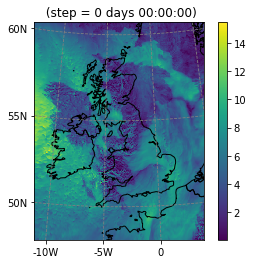

In [251]:
tslice.salem.quick_map()

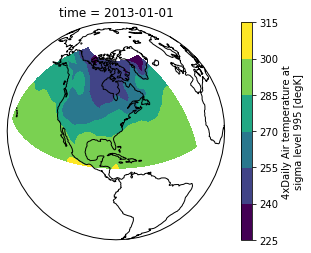

In [208]:
import matplotlib.pyplot as plt
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-80, central_latitude=35))
air.isel(time=0).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.set_global()
ax.coastlines();

In [199]:
ccrs.Orthographic?

Init signature: ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0, globe=None)
Docstring:     
Define a projected coordinate system with flat topology and Euclidean
distance.
Init docstring:
Parameters
----------
proj4_params: iterable of key-value pairs
    The proj4 parameters required to define the
    desired CRS.  The parameters should not describe
    the desired elliptic model, instead create an
    appropriate Globe instance. The ``proj4_params``
    parameters will override any parameters that the
    Globe defines.
globe: :class:`~cartopy.crs.Globe` instance, optional
    If omitted, the default Globe instance will be created.
    See :class:`~cartopy.crs.Globe` for details.
File:           ~/miniconda3/envs/nwp/lib/python3.7/site-packages/cartopy/crs.py
Type:           ABCMeta
Subclasses:     
